In [ ]:
# Combine quartile results and create visualizations
if mimic_quartiles is not None or eicu_quartiles is not None:
    
    # Combine results
    all_quartiles = []
    if mimic_quartiles is not None:
        all_quartiles.append(mimic_quartiles)
    if eicu_quartiles is not None:
        all_quartiles.append(eicu_quartiles)
    
    if all_quartiles:
        combined_quartiles = pd.concat(all_quartiles, ignore_index=True)
        
        print("\n📊 SUMMARY TABLE: Quartile Cutoffs by ARDS Severity")
        print("=" * 70)
        
        # Create summary table
        summary_cols = ['dataset', 'ards_severity', 'n_patients', 'q1_days', 'median_days', 'q3_days', 'mean_days']
        summary_table = combined_quartiles[summary_cols].round(2)
        
        # Display formatted table
        for dataset in summary_table['dataset'].unique():
            dataset_data = summary_table[summary_table['dataset'] == dataset]
            print(f"\n{dataset}:")
            print(dataset_data[['ards_severity', 'n_patients', 'q1_days', 'median_days', 'q3_days', 'mean_days']].to_string(index=False))
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        severities = ['Mild', 'Moderate', 'Severe']
        colors = ['#2E8B57', '#32CD32', '#FFD700', '#FF6347']  # Early, Med-Early, Med-Late, Late
        
        for idx, severity in enumerate(severities):
            ax = axes[idx]
            
            # Get data for this severity
            severity_data = combined_quartiles[combined_quartiles['ards_severity'] == severity]
            
            if len(severity_data) > 0:
                # Prepare data for stacked bar plot
                datasets = severity_data['dataset'].tolist()
                
                early = severity_data['early_pct'].tolist()
                med_early = severity_data['med_early_pct'].tolist()
                med_late = severity_data['med_late_pct'].tolist()
                late = severity_data['late_pct'].tolist()
                
                # Create stacked bar chart
                bar_width = 0.6
                x_pos = np.arange(len(datasets))
                
                p1 = ax.bar(x_pos, early, bar_width, label='Early (≤Q1)', color=colors[0])
                p2 = ax.bar(x_pos, med_early, bar_width, bottom=early, label='Med-Early (Q1-Q2)', color=colors[1]) 
                p3 = ax.bar(x_pos, med_late, bar_width, bottom=np.array(early)+np.array(med_early), label='Med-Late (Q2-Q3)', color=colors[2])
                p4 = ax.bar(x_pos, late, bar_width, bottom=np.array(early)+np.array(med_early)+np.array(med_late), label='Late (>Q3)', color=colors[3])
                
                ax.set_title(f'{severity} ARDS\\n(S/F: {"<148" if severity=="Severe" else "148-235" if severity=="Moderate" else "<315"})', 
                           fontsize=14, fontweight='bold')
                ax.set_ylabel('Percentage of Patients (%)' if idx == 0 else '', fontsize=12)
                ax.set_xticks(x_pos)
                ax.set_xticklabels(datasets, fontsize=11)
                ax.set_ylim(0, 100)
                
                # Add patient counts as text
                for i, dataset in enumerate(datasets):
                    n_patients = severity_data[severity_data['dataset'] == dataset]['n_patients'].iloc[0]
                    ax.text(i, 102, f'n={n_patients}', ha='center', va='bottom', fontweight='bold')
                    
                    # Add quartile cutoffs as text
                    q1 = severity_data[severity_data['dataset'] == dataset]['q1_days'].iloc[0]
                    q2 = severity_data[severity_data['dataset'] == dataset]['median_days'].iloc[0]
                    q3 = severity_data[severity_data['dataset'] == dataset]['q3_days'].iloc[0]
                    ax.text(i, -15, f'Q1={q1:.1f}d\\nQ2={q2:.1f}d\\nQ3={q3:.1f}d', 
                           ha='center', va='top', fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No Data\\nAvailable', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=16, style='italic')
                ax.set_title(f'{severity} ARDS\\n(S/F: {"<148" if severity=="Severe" else "148-235" if severity=="Moderate" else "<315"})', 
                           fontsize=14, fontweight='bold')
                ax.set_ylim(0, 100)
        
        # Add legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)
        
        plt.suptitle('Timing Quartiles for Prone Positioning by ARDS Severity\\n(Time from ARDS Diagnosis to First Prone Event)', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2, top=0.85)
        
        # Create output directory
        os.makedirs('figures', exist_ok=True)
        plt.savefig('figures/proning_quartiles_by_severity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save detailed results
        combined_quartiles.to_csv('quartile_analysis_results.csv', index=False)
        print("\\n💾 Detailed quartile results saved to: quartile_analysis_results.csv")
        
        # Clinical interpretation
        print("\\n🏥 CLINICAL INTERPRETATION:")
        print("=" * 50)
        print("• Early proning (≤Q1): Aggressive early intervention")
        print("• Med-Early (Q1-Q2): Standard early intervention") 
        print("• Med-Late (Q2-Q3): Delayed intervention")
        print("• Late (>Q3): Very delayed intervention")
        print("\\nThese quartiles provide a framework for studying the")
        print("effectiveness of timing-based prone positioning strategies")
        print("in different ARDS severity categories.")
        
        # Summary statistics by severity
        print("\\n📈 KEY FINDINGS:")
        print("=" * 30)
        for _, row in combined_quartiles.iterrows():
            print(f"{row['dataset']} - {row['ards_severity']} ARDS:")
            print(f"  • {row['n_patients']} patients analyzed")
            print(f"  • Median time to proning: {row['median_days']:.1f} days")
            print(f"  • Early cutoff (Q1): ≤{row['q1_days']:.1f} days")
            print(f"  • Late cutoff (Q3): >{row['q3_days']:.1f} days")
        
else:
    print("\\n❌ No quartile analysis results available")
    print("Possible reasons:")
    print("• Insufficient proning events in the datasets")
    print("• Missing required columns (prone_flag, time_from_ARDS_onset, ards_severity)")
    print("• Data quality issues with timing variables")

In [ ]:
def analyze_proning_quartiles_by_severity(data, dataset_name):
    """
    Analyze time to proning quartiles by ARDS severity
    
    Parameters:
    - data: DataFrame with time series data
    - dataset_name: String identifier for the dataset
    
    Returns:
    - DataFrame with quartile analysis results
    """
    if data is None:
        return None
    
    print(f"\n=== {dataset_name} Proning Quartile Analysis ===")
    
    # Ensure we have the required columns
    required_cols = ['prone_flag', 'time_from_ARDS_onset', 'ards_severity']
    if not all(col in data.columns for col in required_cols):
        print(f"Missing required columns in {dataset_name}")
        print(f"Available columns: {list(data.columns)}")
        return None
    
    # Filter to only ARDS patients who were proned
    ards_data = data[data['ards_severity'].isin(['Mild', 'Moderate', 'Severe'])].copy()
    proned_data = ards_data[ards_data['prone_flag'] == 1].copy()
    
    print(f"Total ARDS patients: {len(ards_data)}")
    print(f"Proned ARDS patients: {len(proned_data)}")
    
    if len(proned_data) == 0:
        print(f"No prone positioning events found in {dataset_name}")
        return None
    
    # Get first prone event for each patient by severity
    first_prone_by_severity = []
    
    for severity in ['Mild', 'Moderate', 'Severe']:
        severity_data = proned_data[proned_data['ards_severity'] == severity]
        
        if len(severity_data) == 0:
            print(f"No {severity} ARDS patients with proning")
            continue
            
        # Get first prone event per patient
        first_prone = severity_data.groupby('patient_id')['time_from_ARDS_onset'].min().reset_index()
        first_prone['ards_severity'] = severity
        first_prone['dataset'] = dataset_name
        
        # Convert hours to days for easier interpretation
        first_prone['time_to_prone_days'] = first_prone['time_from_ARDS_onset'] / 24
        
        # Filter reasonable values (within 14 days and ≥0)
        first_prone = first_prone[
            (first_prone['time_to_prone_days'] >= 0) & 
            (first_prone['time_to_prone_days'] <= 14)
        ]
        
        print(f"{severity} ARDS: {len(first_prone)} patients with valid proning times")
        
        if len(first_prone) > 0:
            first_prone_by_severity.append(first_prone)
    
    if not first_prone_by_severity:
        print(f"No valid prone timing data found in {dataset_name}")
        return None
    
    # Combine all severities
    all_prone_times = pd.concat(first_prone_by_severity, ignore_index=True)
    
    # Calculate quartiles by severity
    quartile_results = []
    
    for severity in ['Mild', 'Moderate', 'Severe']:
        severity_times = all_prone_times[all_prone_times['ards_severity'] == severity]['time_to_prone_days']
        
        if len(severity_times) < 4:  # Need at least 4 patients for quartiles
            print(f"Insufficient data for {severity} ARDS quartile analysis (n={len(severity_times)})")
            continue
        
        # Calculate quartiles
        q1 = severity_times.quantile(0.25)
        q2 = severity_times.quantile(0.50)  # median
        q3 = severity_times.quantile(0.75)
        
        # Create quartile categories
        severity_data = all_prone_times[all_prone_times['ards_severity'] == severity].copy()
        
        # Assign quartile categories
        severity_data['timing_quartile'] = pd.cut(
            severity_data['time_to_prone_days'],
            bins=[0, q1, q2, q3, severity_data['time_to_prone_days'].max() + 0.1],
            labels=['Early', 'Med-Early', 'Med-Late', 'Late'],
            include_lowest=True
        )
        
        # Calculate summary statistics
        quartile_summary = {
            'ards_severity': severity,
            'dataset': dataset_name,
            'n_patients': len(severity_times),
            'q1_days': q1,
            'median_days': q2,
            'q3_days': q3,
            'mean_days': severity_times.mean(),
            'std_days': severity_times.std(),
            'early_cutoff': q1,
            'med_early_cutoff': q2,
            'med_late_cutoff': q3
        }
        
        # Count patients in each quartile
        quartile_counts = severity_data['timing_quartile'].value_counts()
        for quartile in ['Early', 'Med-Early', 'Med-Late', 'Late']:
            quartile_summary[f'{quartile.lower()}_n'] = quartile_counts.get(quartile, 0)
            quartile_summary[f'{quartile.lower()}_pct'] = (quartile_counts.get(quartile, 0) / len(severity_times)) * 100
        
        quartile_results.append(quartile_summary)
        
        # Print detailed results
        print(f"\n{severity} ARDS (n={len(severity_times)}):")
        print(f"  Quartile cutoffs (days): Q1={q1:.2f}, Q2={q2:.2f}, Q3={q3:.2f}")
        print(f"  Mean ± SD: {severity_times.mean():.2f} ± {severity_times.std():.2f} days")
        print(f"  Quartile distribution:")
        for quartile in ['Early', 'Med-Early', 'Med-Late', 'Late']:
            count = quartile_counts.get(quartile, 0)
            pct = (count / len(severity_times)) * 100
            cutoff_info = ""
            if quartile == 'Early':
                cutoff_info = f" (≤{q1:.2f} days)"
            elif quartile == 'Med-Early':
                cutoff_info = f" ({q1:.2f}-{q2:.2f} days)"
            elif quartile == 'Med-Late':
                cutoff_info = f" ({q2:.2f}-{q3:.2f} days)"
            elif quartile == 'Late':
                cutoff_info = f" (>{q3:.2f} days)"
            print(f"    {quartile}{cutoff_info}: {count} patients ({pct:.1f}%)")
    
    return pd.DataFrame(quartile_results) if quartile_results else None

# Run quartile analysis for both datasets
print("🔍 QUARTILE ANALYSIS: Time to Proning by ARDS Severity")
print("=" * 70)

# MIMIC Analysis
mimic_quartiles = None
if mimic_data is not None:
    mimic_quartiles = analyze_proning_quartiles_by_severity(mimic_data, 'MIMIC-IV')

# eICU Analysis  
eicu_quartiles = None
if eicu_patient_data is not None:
    eicu_quartiles = analyze_proning_quartiles_by_severity(eicu_patient_data, 'eICU-CRD')

## 8. Quartile Analysis: Time to Proning by ARDS Severity

This section analyzes the timing of prone positioning from ARDS diagnosis, stratified by ARDS severity categories:
- **Mild ARDS**: S/F ratio <315 (but >235)
- **Moderate ARDS**: S/F ratio 148-235
- **Severe ARDS**: S/F ratio <148

We'll create quartile-based timing categories: **Early**, **Med-Early**, **Med-Late**, and **Late**.

In [ ]:
# Combine quartile results and create visualizations
if mimic_quartiles is not None or eicu_quartiles is not None:
    
    # Combine results
    all_quartiles = []
    if mimic_quartiles is not None:
        all_quartiles.append(mimic_quartiles)
    if eicu_quartiles is not None:
        all_quartiles.append(eicu_quartiles)
    
    if all_quartiles:
        combined_quartiles = pd.concat(all_quartiles, ignore_index=True)
        
        print("\n📊 SUMMARY TABLE: Quartile Cutoffs by ARDS Severity")
        print("=" * 70)
        
        # Create summary table
        summary_cols = ['dataset', 'ards_severity', 'n_patients', 'q1_days', 'median_days', 'q3_days', 'mean_days']
        summary_table = combined_quartiles[summary_cols].round(2)
        
        # Display formatted table
        for dataset in summary_table['dataset'].unique():
            dataset_data = summary_table[summary_table['dataset'] == dataset]
            print(f"\n{dataset}:")
            print(dataset_data[['ards_severity', 'n_patients', 'q1_days', 'median_days', 'q3_days', 'mean_days']].to_string(index=False))
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        severities = ['Mild', 'Moderate', 'Severe']
        quartile_labels = ['Early\n(≤Q1)', 'Med-Early\n(Q1-Q2)', 'Med-Late\n(Q2-Q3)', 'Late\n(>Q3)']
        
        for idx, severity in enumerate(severities):
            ax = axes[idx]
            
            # Get data for this severity
            severity_data = combined_quartiles[combined_quartiles['ards_severity'] == severity]
            
            if len(severity_data) > 0:
                # Prepare data for stacked bar plot
                datasets = severity_data['dataset'].tolist()
                
                early = severity_data['early_pct'].tolist()
                med_early = severity_data['med_early_pct'].tolist()
                med_late = severity_data['med_late_pct'].tolist()
                late = severity_data['late_pct'].tolist()
                
                # Create stacked bar chart
                bar_width = 0.6
                x_pos = np.arange(len(datasets))
                
                p1 = ax.bar(x_pos, early, bar_width, label='Early', color='#2E8B57')
                p2 = ax.bar(x_pos, med_early, bar_width, bottom=early, label='Med-Early', color='#32CD32') 
                p3 = ax.bar(x_pos, med_late, bar_width, bottom=np.array(early)+np.array(med_early), label='Med-Late', color='#FFD700')
                p4 = ax.bar(x_pos, late, bar_width, bottom=np.array(early)+np.array(med_early)+np.array(med_late), label='Late', color='#FF6347')
                
                ax.set_title(f'{severity} ARDS', fontsize=14, fontweight='bold')
                ax.set_ylabel('Percentage of Patients (%)', fontsize=12)
                ax.set_xticks(x_pos)
                ax.set_xticklabels(datasets, fontsize=11)
                ax.set_ylim(0, 100)
                
                # Add patient counts as text
                for i, dataset in enumerate(datasets):
                    n_patients = severity_data[severity_data['dataset'] == dataset]['n_patients'].iloc[0]
                    ax.text(i, 102, f'n={n_patients}', ha='center', va='bottom', fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes, fontsize=16)
                ax.set_title(f'{severity} ARDS', fontsize=14, fontweight='bold')
        
        # Add legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)
        
        plt.suptitle('Timing Quartiles for Prone Positioning by ARDS Severity', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.savefig('figures/proning_quartiles_by_severity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save detailed results
        combined_quartiles.to_csv('quartile_analysis_results.csv', index=False)
        print("\n💾 Detailed quartile results saved to: quartile_analysis_results.csv")
        
        # Clinical interpretation
        print("\n🏥 CLINICAL INTERPRETATION:")
        print("=" * 50)
        print("• Early proning (≤Q1): Aggressive early intervention")
        print("• Med-Early (Q1-Q2): Standard early intervention") 
        print("• Med-Late (Q2-Q3): Delayed intervention")
        print("• Late (>Q3): Very delayed intervention")
        print("\nThese quartiles can be used to categorize proning timing in")
        print("future analyses of effectiveness by intervention timing.")
        
else:
    print("\n❌ No quartile analysis results available - insufficient proning data in both datasets")

In [ ]:
def analyze_proning_quartiles_by_severity(data, dataset_name):
    """
    Analyze time to proning quartiles by ARDS severity
    
    Parameters:
    - data: DataFrame with time series data
    - dataset_name: String identifier for the dataset
    
    Returns:
    - DataFrame with quartile analysis results
    """
    if data is None:
        return None
    
    print(f"\n=== {dataset_name} Proning Quartile Analysis ===")
    
    # Ensure we have the required columns
    required_cols = ['prone_flag', 'time_from_ARDS_onset', 'ards_severity']
    if not all(col in data.columns for col in required_cols):
        print(f"Missing required columns in {dataset_name}")
        return None
    
    # Filter to only ARDS patients who were proned
    ards_data = data[data['ards_severity'].isin(['Mild', 'Moderate', 'Severe'])].copy()
    proned_data = ards_data[ards_data['prone_flag'] == 1].copy()
    
    if len(proned_data) == 0:
        print(f"No prone positioning events found in {dataset_name}")
        return None
    
    # Get first prone event for each patient by severity
    first_prone_by_severity = []
    
    for severity in ['Mild', 'Moderate', 'Severe']:
        severity_data = proned_data[proned_data['ards_severity'] == severity]
        
        if len(severity_data) == 0:
            continue
            
        # Get first prone event per patient
        first_prone = severity_data.groupby('patient_id')['time_from_ARDS_onset'].min().reset_index()
        first_prone['ards_severity'] = severity
        first_prone['dataset'] = dataset_name
        
        # Convert hours to days for easier interpretation
        first_prone['time_to_prone_days'] = first_prone['time_from_ARDS_onset'] / 24
        
        # Filter reasonable values (within 14 days)
        first_prone = first_prone[
            (first_prone['time_to_prone_days'] >= 0) & 
            (first_prone['time_to_prone_days'] <= 14)
        ]
        
        if len(first_prone) > 0:
            first_prone_by_severity.append(first_prone)
    
    if not first_prone_by_severity:
        print(f"No valid prone timing data found in {dataset_name}")
        return None
    
    # Combine all severities
    all_prone_times = pd.concat(first_prone_by_severity, ignore_index=True)
    
    # Calculate quartiles by severity
    quartile_results = []
    
    for severity in ['Mild', 'Moderate', 'Severe']:
        severity_times = all_prone_times[all_prone_times['ards_severity'] == severity]['time_to_prone_days']
        
        if len(severity_times) < 4:  # Need at least 4 patients for quartiles
            print(f"Insufficient data for {severity} ARDS quartile analysis (n={len(severity_times)})")
            continue
        
        # Calculate quartiles
        q1 = severity_times.quantile(0.25)
        q2 = severity_times.quantile(0.50)  # median
        q3 = severity_times.quantile(0.75)
        
        # Create quartile categories
        severity_data = all_prone_times[all_prone_times['ards_severity'] == severity].copy()
        
        # Assign quartile categories
        severity_data['timing_quartile'] = pd.cut(
            severity_data['time_to_prone_days'],
            bins=[0, q1, q2, q3, severity_data['time_to_prone_days'].max() + 0.1],
            labels=['Early', 'Med-Early', 'Med-Late', 'Late'],
            include_lowest=True
        )
        
        # Calculate summary statistics
        quartile_summary = {
            'ards_severity': severity,
            'dataset': dataset_name,
            'n_patients': len(severity_times),
            'q1_days': q1,
            'median_days': q2,
            'q3_days': q3,
            'mean_days': severity_times.mean(),
            'std_days': severity_times.std(),
            'early_cutoff': q1,
            'med_early_cutoff': q2,
            'med_late_cutoff': q3
        }
        
        # Count patients in each quartile
        quartile_counts = severity_data['timing_quartile'].value_counts()
        for quartile in ['Early', 'Med-Early', 'Med-Late', 'Late']:
            quartile_summary[f'{quartile.lower()}_n'] = quartile_counts.get(quartile, 0)
            quartile_summary[f'{quartile.lower()}_pct'] = (quartile_counts.get(quartile, 0) / len(severity_times)) * 100
        
        quartile_results.append(quartile_summary)
        
        # Print detailed results
        print(f"\n{severity} ARDS (n={len(severity_times)}):")
        print(f"  Quartile cutoffs (days): Q1={q1:.2f}, Q2={q2:.2f}, Q3={q3:.2f}")
        print(f"  Mean ± SD: {severity_times.mean():.2f} ± {severity_times.std():.2f} days")
        print(f"  Quartile distribution:")
        for quartile in ['Early', 'Med-Early', 'Med-Late', 'Late']:
            count = quartile_counts.get(quartile, 0)
            pct = (count / len(severity_times)) * 100
            print(f"    {quartile}: {count} patients ({pct:.1f}%)")
    
    return pd.DataFrame(quartile_results) if quartile_results else None

# Run quartile analysis for both datasets
print("🔍 QUARTILE ANALYSIS: Time to Proning by ARDS Severity")
print("=" * 70)

# MIMIC Analysis
mimic_quartiles = None
if mimic_data is not None:
    mimic_quartiles = analyze_proning_quartiles_by_severity(mimic_data, 'MIMIC-IV')

# eICU Analysis  
eicu_quartiles = None
if eicu_patient_data is not None:
    eicu_quartiles = analyze_proning_quartiles_by_severity(eicu_patient_data, 'eICU-CRD')

## 8. Quartile Analysis: Time to Proning by ARDS Severity

This section analyzes the timing of prone positioning from ARDS diagnosis, stratified by ARDS severity categories:
- **Mild ARDS**: S/F ratio 235-315 
- **Moderate ARDS**: S/F ratio 148-235
- **Severe ARDS**: S/F ratio <148

We'll create quartile-based timing categories: **Early**, **Med-Early**, **Med-Late**, and **Late**.

# Statistical Analysis: MIMIC vs eICU ARDS Cohorts

This notebook performs statistical analysis comparing ARDS cohorts from:
- **MIMIC-IV** (Training dataset)
- **eICU-CRD** (Validation dataset)

## Analysis Plan:
1. Load and harmonize both datasets
2. Create Table 1 descriptive statistics
3. Visualize practice differences (time to proning, NMB use)
4. Analyze outcomes by ARDS severity

## 1. Setup and Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne
import scipy.stats as stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Install tableone if needed
# !pip install tableone

# Define data paths
DATA_PATH = '/Users/kavenchhikara/Desktop/projects/SCCM/SCCM-Team2/ards_analysis/data'

# Try to load MIMIC data
try:
    # Try time series data first
    mimic_ts = pd.read_parquet(f'{DATA_PATH}/time_series_analysis_table.parquet')
    mimic_static = pd.read_parquet(f'{DATA_PATH}/static_analysis_table.parquet')
    print(f"Loaded MIMIC data: {len(mimic_ts)} time series records, {len(mimic_static)} patients")
    mimic_source = 'parquet'
except:
    try:
        # Try CSV if parquet fails
        mimic_ts = pd.read_csv(f'{DATA_PATH}/time_series_analysis_table.csv')
        mimic_static = pd.read_csv(f'{DATA_PATH}/static_analysis_table.csv')
        print(f"Loaded MIMIC data from CSV: {len(mimic_ts)} time series records, {len(mimic_static)} patients")
        mimic_source = 'csv'
    except:
        print("Could not load MIMIC data. Please check file paths.")
        mimic_ts = None
        mimic_static = None

# Try to load eICU data (exploded format) - UPDATED SEARCH
try:
    import glob
    import os
    
    # Search for eICU files in notebooks directory and data directory
    eicu_files = glob.glob('/Users/kavenchhikara/Desktop/projects/SCCM/SCCM-Team2/notebooks/ards_*dataset*.csv') + \
                 glob.glob(f'{DATA_PATH}/ards_*dataset*.csv') + \
                 glob.glob('ards_*dataset*.csv')
    
    if eicu_files:
        # Get the most recent file
        latest_eicu = max(eicu_files, key=os.path.getctime)
        eicu_data = pd.read_csv(latest_eicu)
        print(f"Loaded eICU data from: {latest_eicu}")
        print(f"eICU data: {len(eicu_data)} records, {eicu_data['patient_id'].nunique()} patients")
    else:
        print("No eICU exploded dataset found")
        eicu_data = None
except Exception as e:
    print(f"Error loading eICU data: {e}")
    eicu_data = None

In [54]:
# Define data paths
DATA_PATH = '/Users/kavenchhikara/Desktop/projects/SCCM/SCCM-Team2/analysis_dataset'

# Try to load MIMIC data
try:
    # Try time series data first
    mimic_ts = pd.read_parquet(f'{DATA_PATH}/time_series_analysis_table_mimic.parquet')
    mimic_static = pd.read_parquet(f'{DATA_PATH}/static_analysis_table_mimic.parquet')
    print(f"Loaded MIMIC data: {len(mimic_ts)} time series records, {len(mimic_static)} patients")
    mimic_source = 'parquet'
except:
    try:
        # Try CSV if parquet fails
        mimic_ts = pd.read_csv(f'{DATA_PATH}/time_series_analysis_table.csv')
        mimic_static = pd.read_csv(f'{DATA_PATH}/static_analysis_table.csv')
        print(f"Loaded MIMIC data from CSV: {len(mimic_ts)} time series records, {len(mimic_static)} patients")
        mimic_source = 'csv'
    except:
        print("Could not load MIMIC data. Please check file paths.")
        mimic_ts = None
        mimic_static = None

# Try to load eICU data (exploded format)
try:
    # Look for the most recent eICU exploded dataset
    import glob
    import os
    
    # Search for eICU files in current directory or data directory
    eicu_files = glob.glob('eICU2_analysis.csv') + \
                 glob.glob(f'{DATA_PATH}/eICU2_analysis.csv') + \
                 glob.glob('../eICU2_analysis.csv')
    
    if eicu_files:
        # Get the most recent file
        latest_eicu = max(eicu_files, key=os.path.getctime)
        eicu_data = pd.read_csv(latest_eicu)
        print(f"Loaded eICU data from: {latest_eicu}")
        print(f"eICU data: {len(eicu_data)} records, {eicu_data['patient_id'].nunique()} patients")
    else:
        print("No eICU exploded dataset found")
        eicu_data = None
except Exception as e:
    print(f"Error loading eICU data: {e}")
    eicu_data = None

Loaded MIMIC data: 1007358 time series records, 90481 patients
Loaded eICU data from: /Users/kavenchhikara/Desktop/projects/SCCM/SCCM-Team2/analysis_dataset/eICU2_analysis.csv
eICU data: 1206142 records, 16269 patients


In [77]:
# Create unified MIMIC dataset by joining time series and static data
if mimic_ts is not None and mimic_static is not None:
    print("Creating unified MIMIC dataset...")
    
    # Ensure hospitalization_id exists in both datasets
    if 'hospitalization_id' in mimic_ts.columns and 'hospitalization_id' in mimic_static.columns:
        # Perform left join
        mimic_data = mimic_ts.merge(
            mimic_static,
            on=['hospital_id','patient_id','hospitalization_id'],
            how='left'
        )
        print(f"Created unified MIMIC dataset with {len(mimic_data)} records")
    else:
        print("Error: hospitalization_id not found in both MIMIC datasets")
        mimic_data = None
else:
    print("Cannot create unified MIMIC dataset - source data missing")
    mimic_data = None


Creating unified MIMIC dataset...
Created unified MIMIC dataset with 7750657 records


In [59]:
mimic_data.to_parquet(f'{DATA_PATH}/mimic_final.parquet', index=False)
mimic_data.dtypes

hospital_id                        object
patient_id                          int64
hospitalization_id                  int64
recorded_dttm              datetime64[ns]
icu_in_time                datetime64[ns]
icu_type                           object
ARDS_onset_dttm            datetime64[ns]
time_from_ARDS_onset              float64
respiratory_device                 object
ecmo_flag                          object
pao2                              float64
fio2_set                          float64
lpm_set                           float64
spo2                              float64
peep_set                          float64
height_cm                         float64
weight_kg                         float64
cisatracurium_dose                float64
vecuronium_dose                   float64
rocuronium_dose                   float64
atracurium_dose                   float64
pancuronium_dose                  float64
position                           object
new_tracheostomy                  

In [60]:
eicu_data.to_parquet(f'{DATA_PATH}/eicu_final.parquet', index=False)
eicu_data.dtypes

hospital_id               int64
patient_id              float64
hospitalization_id        int64
recorded_dttm            object
ARDS_onset_time           int64
time_from_ARDS_onset    float64
APACHE                  float64
sex                      object
age_at_admission          int64
ethinicity               object
disposition_category     object
respiratory_device       object
ecmo_flag                 int64
pao2                    float64
fio2_set                float64
lmp_set                 float64
spo2                    float64
peep                    float64
height_cm               float64
weight_kg               float64
nmb_used                float64
cisatracurium_dose      float64
vecuronium_dose         float64
rocuronium_dose         float64
atracurium_dose         float64
pancuronium_dose        float64
prone_flag                int64
new_tracheostomy          int64
dtype: object

# Function to harmonize dataset structure

In [ ]:
# # Function to harmonize dataset structure
# def harmonize_datasets(mimic_ts, mimic_static, eicu_data):
#     """
#     Harmonize MIMIC and eICU datasets to have the same structure
#     """
    
#     # First, create a unified MIMIC dataset from time series and static
#     if mimic_ts is not None and mimic_static is not None:
#         print("Creating MIMIC patient-level dataset...")
        
#         # CRITICAL: Clean and convert binary columns to numeric BEFORE any aggregation
#         print("Cleaning binary columns...")
#         binary_cols = ['prone_flag', 'new_tracheostomy']
#         for col in binary_cols:
#             if col in mimic_ts.columns:
#                 print(f"Converting {col} to numeric...")
#                 # Convert to numeric, coercing non-numeric to NaN
#                 mimic_ts[col] = pd.to_numeric(mimic_ts[col], errors='coerce')
#                 # Fill NaN with 0 and convert to int
#                 mimic_ts[col] = mimic_ts[col].fillna(0).astype(int)
#                 print(f"{col} data type after conversion: {mimic_ts[col].dtype}")
        
#         # Also clean respiratory columns
#         resp_cols = ['peep_set', 'fio2_set', 'spo2', 'pao2']
#         for col in resp_cols:
#             if col in mimic_ts.columns:
#                 mimic_ts[col] = pd.to_numeric(mimic_ts[col], errors='coerce')
        
#         # Now do the aggregation with ALL lambda functions to avoid mixing types
#         agg_dict = {}
        
#         # Use lambda for ALL columns to ensure consistent handling
#         for col in resp_cols:
#             if col in mimic_ts.columns:
#                 agg_dict[col] = lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else np.nan
        
#         # Use lambda for binary columns too (safer than 'max')
#         for col in binary_cols:
#             if col in mimic_ts.columns:
#                 agg_dict[col] = lambda x: x.max() if len(x) > 0 else 0
        
#         print("Performing aggregation...")
#         mimic_first_values = mimic_ts.groupby('hospitalization_id').agg(agg_dict).reset_index()
        
#         # Get NMB usage - handle NMB columns properly
#         nmb_cols = [
#             'cisatracurium_dose', 'vecuronium_dose', 'rocuronium_dose',
#             'atracurium_dose', 'pancuronium_dose'
#         ]
        
#         # Check which NMB columns exist and convert to numeric
#         existing_nmb_cols = [col for col in nmb_cols if col in mimic_ts.columns]
#         if existing_nmb_cols:
#             for col in existing_nmb_cols:
#                 mimic_ts[col] = pd.to_numeric(mimic_ts[col], errors='coerce').fillna(0)
            
#             # Check if any NMB dose > 0
#             mimic_nmb = (mimic_ts[existing_nmb_cols] > 0).any(axis=1)
#             mimic_ts['nmb_used'] = mimic_nmb.astype(int)
#             mimic_nmb_usage = mimic_ts.groupby('hospitalization_id')['nmb_used'].max().reset_index()
#         else:
#             # Create empty NMB usage if no columns found
#             unique_patients = mimic_ts['hospitalization_id'].unique()
#             mimic_nmb_usage = pd.DataFrame({
#                 'hospitalization_id': unique_patients,
#                 'nmb_used': 0
#             })
        
#         # Merge with static data
#         mimic_unified = mimic_static.merge(mimic_first_values, on='hospitalization_id', how='left')
#         mimic_unified = mimic_unified.merge(mimic_nmb_usage, on='hospitalization_id', how='left')
        
#         # Add dataset label
#         mimic_unified['dataset'] = 'MIMIC-IV'
        
#         # Rename columns to match eICU format
#         mimic_unified = mimic_unified.rename(columns={
#             'hospitalization_id': 'patient_id',
#             'age_at_admission': 'age',
#             'sex': 'gender',
#             'peep_set': 'peep',
#             'fio2_set': 'fio2'
#         })
        
#     else:
#         mimic_unified = None
        
#     # Process eICU data
#     if eicu_data is not None:
#         print("Creating eICU patient-level dataset...")
        
#         # Clean eICU binary columns too
#         binary_cols = ['nmb_used', 'prone_flag', 'new_tracheostomy', 'ecmo_flag']
#         for col in binary_cols:
#             if col in eicu_data.columns:
#                 eicu_data[col] = pd.to_numeric(eicu_data[col], errors='coerce').fillna(0).astype(int)
        
#         # Use only lambda functions for eICU too
#         agg_dict = {}
        
#         # Basic info columns
#         info_cols = [
#             'hospital_id', 'hospitalization_id', 'sex', 'age_at_admission',
#             'ethinicity', 'disposition_category', 'height_cm', 'weight_kg'
#         ]
#         for col in info_cols:
#             if col in eicu_data.columns:
#                 agg_dict[col] = lambda x: x.iloc[0] if len(x) > 0 else None
        
#         # Respiratory parameters
#         resp_cols = ['peep', 'fio2_set', 'spo2', 'pao2']
#         for col in resp_cols:
#             if col in eicu_data.columns:
#                 # Convert to numeric first
#                 eicu_data[col] = pd.to_numeric(eicu_data[col], errors='coerce')
#                 agg_dict[col] = lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else np.nan
        
#         # Binary columns - use lambda
#         for col in binary_cols:
#             if col in eicu_data.columns:
#                 agg_dict[col] = lambda x: x.max() if len(x) > 0 else 0
        
#         eicu_first_values = eicu_data.groupby('patient_id').agg(agg_dict).reset_index()
        
#         # Add dataset label
#         eicu_first_values['dataset'] = 'eICU-CRD'
        
#         # Rename columns for consistency
#         rename_dict = {
#             'sex': 'gender',
#             'age_at_admission': 'age',
#             'ethinicity': 'ethnicity',
#             'fio2_set': 'fio2'
#         }
#         eicu_first_values = eicu_first_values.rename(columns=rename_dict)
        
#         # Calculate mortality (assuming 'Expired' in disposition means death)
#         if 'disposition_category' in eicu_first_values.columns:
#             eicu_first_values['mortality'] = (eicu_first_values['disposition_category'] == 'Expired').astype(int)
#         else:
#             eicu_first_values['mortality'] = 0
        
#     else:
#         eicu_first_values = None
        
#     return mimic_unified, eicu_first_values

# # Harmonize the datasets
# mimic_data_har, eicu_patient_data_har = harmonize_datasets(mimic_ts, mimic_static, eicu_data)

## 4. Common Variables and Data Types

In [64]:
# Define common variables for analysis
common_vars = [
    'patient_id', 'age', 'sex', 'mortality', 
    'peep', 'fio2', 'spo2', 'pao2',
    'nmb_used', 'prone_flag', 'new_tracheostomy'
]

# Additional variables if available
optional_vars = ['height_cm', 'weight_kg']

# Function to standardize data types
def standardize_datatypes(df, dataset_name):
    """
    Standardize data types across datasets
    """
    if df is None:
        return None
        
    print(f"\nStandardizing {dataset_name} data types...")
    
    # Numeric variables
    numeric_vars = ['age', 'peep', 'fio2', 'spo2', 'pao2', 'height_cm', 'weight_kg', 'APACHE']
    for var in numeric_vars:
        if var in df.columns:
            df[var] = pd.to_numeric(df[var], errors='coerce')
    
    # Binary variables
    binary_vars = ['mortality', 'nmb_used', 'prone_flag', 'new_tracheostomy']
    for var in binary_vars:
        if var in df.columns:
            df[var] = df[var].fillna(0).astype(int)
    
    # Categorical variables
    if 'sex' in df.columns:
        df['sex'] = df['sex'].astype(str)
        
    # Calculate P/F ratio if both available
    if 'pao2' in df.columns and 'fio2_set' in df.columns:
        df['pf_ratio'] = df['pao2'] / (df['fio2_set'] / 100)
        df.loc[df['fio2_set'] < 21, 'pf_ratio'] = np.nan  # Invalid FiO2
        
    # Calculate S/F ratio if both available
    if 'spo2' in df.columns and 'fio2_set' in df.columns:
        df['sf_ratio'] = df['spo2'] / (df['fio2_set'] / 100)
        df.loc[df['fio2_set'] < 21, 'sf_ratio'] = np.nan  # Invalid FiO2
        
    # ARDS severity based on P/F ratio (Berlin criteria)
    # if 'pf_ratio' in df.columns:
    #     df['ards_severity'] = pd.cut(
    #         df['pf_ratio'],
    #         bins=[0, 100, 200, 300, np.inf],
    #         labels=['Severe', 'Moderate', 'Mild', 'Non-ARDS'],
    #         ordered=True
    #     )
    # elif 'sf_ratio' in df.columns:
        # Use S/F ratio approximation if P/F not available
    df['ards_severity'] = pd.cut(
        df['sf_ratio'],
        bins=[0, 88, 181, 315, np.inf],  # Approximate S/F cutoffs
        labels=['Severe', 'Moderate', 'Mild', 'Non-ARDS'],
        ordered=True
    )
        
    return df

# Standardize both datasets
mimic_data = standardize_datatypes(mimic_data, 'MIMIC')
eicu_patient_data = standardize_datatypes(eicu_data, 'eICU')

# Show data info
if mimic_data is not None:
    print(f"\nMIMIC data shape: {mimic_data.shape}")
    print(f"MIMIC columns: {list(mimic_data.columns)}")
    
if eicu_patient_data is not None:
    print(f"\neICU data shape: {eicu_patient_data.shape}")
    print(f"eICU columns: {list(eicu_patient_data.columns)}")


Standardizing MIMIC data types...

Standardizing eICU data types...

MIMIC data shape: (7750657, 40)
MIMIC columns: ['hospital_id', 'patient_id', 'hospitalization_id', 'recorded_dttm', 'icu_in_time', 'icu_type', 'ARDS_onset_dttm', 'time_from_ARDS_onset', 'respiratory_device', 'ecmo_flag', 'pao2', 'fio2_set', 'lpm_set', 'spo2', 'peep_set', 'height_cm', 'weight_kg', 'cisatracurium_dose', 'vecuronium_dose', 'rocuronium_dose', 'atracurium_dose', 'pancuronium_dose', 'position', 'new_tracheostomy', 'prone_flag', 'nmb_used', 'admission_datetime', 'discharge_datetime', 'sex', 'age_at_admission', 'disposition_category', 'hospital_admit_source', 'mortality', 'icu_los_days', 'hospital_los_days', 'ventilator_free_days_28', 'race', 'pf_ratio', 'sf_ratio', 'ards_severity']

eICU data shape: (1206142, 31)
eICU columns: ['hospital_id', 'patient_id', 'hospitalization_id', 'recorded_dttm', 'ARDS_onset_time', 'time_from_ARDS_onset', 'APACHE', 'sex', 'age_at_admission', 'ethinicity', 'disposition_categor

## 5. Table 1: Descriptive Statistics

In [65]:
# Create separate Table 1 for MIMIC and eICU
def prepare_dataset_for_table1(df):
    """
    Prepare a dataset for Table 1 by selecting relevant columns
    """
    if df is None:
        return None
        
    cols_to_use = [col for col in common_vars + optional_vars if col in df.columns]
    if 'pf_ratio' in df.columns:
        cols_to_use.append('pf_ratio')
    if 'sf_ratio' in df.columns:
        cols_to_use.append('sf_ratio') 
    if 'ards_severity' in df.columns:
        cols_to_use.append('ards_severity')
    
    return df[cols_to_use]

# Prepare MIMIC data
mimic_table1 = prepare_dataset_for_table1(mimic_data)
if mimic_table1 is not None:
    print(f"\nMIMIC dataset: {len(mimic_table1)} patients")
    print(f"MIMIC columns: {list(mimic_table1.columns)}")

# Prepare eICU data  
eicu_table1 = prepare_dataset_for_table1(eicu_patient_data)
if eicu_table1 is not None:
    print(f"\neICU dataset: {len(eicu_table1)} patients")
    print(f"eICU columns: {list(eicu_table1.columns)}")


MIMIC dataset: 7750657 patients
MIMIC columns: ['patient_id', 'sex', 'mortality', 'spo2', 'pao2', 'nmb_used', 'prone_flag', 'new_tracheostomy', 'height_cm', 'weight_kg', 'pf_ratio', 'sf_ratio', 'ards_severity']

eICU dataset: 1206142 patients
eICU columns: ['patient_id', 'sex', 'peep', 'spo2', 'pao2', 'nmb_used', 'prone_flag', 'new_tracheostomy', 'height_cm', 'weight_kg', 'pf_ratio', 'sf_ratio', 'ards_severity']


In [ ]:
# Create separate Table 1 for MIMIC and eICU
# Define variables for Table 1
table1_vars = [
    'age', 'gender', 'mortality',
    'peep', 'fio2', 'spo2', 'pao2', 
    'pf_ratio', 'sf_ratio', 'ards_severity',
    'nmb_used', 'prone_flag', 'new_tracheostomy'
]

# Define categorical variables
categorical = ['gender', 'mortality', 'ards_severity', 'nmb_used', 'prone_flag', 'new_tracheostomy']

# Create MIMIC Table 1
if mimic_table1 is not None and len(mimic_table1) > 0:
    # Filter to only ARDS patients before any processing
    # mimic_table1 = mimic_table1[(mimic_table1['ards_severity'].notna()) & (mimic_table1['ards_severity'] != 'Non-ARDS')].copy()
    print(f"\nFiltered to {len(mimic_table1)} ARDS patients from MIMIC")
    
    # Add optional variables if present
    for var in ['height_cm', 'weight_kg', 'ecmo_flag']:
        if var in mimic_table1.columns and mimic_table1[var].notna().sum() > 0:
            table1_vars.append(var)
            if var == 'ecmo_flag':
                categorical.append(var)
    
    # Remove variables not present
    mimic_vars = [var for var in table1_vars if var in mimic_table1.columns]
    mimic_cats = [var for var in categorical if var in mimic_table1.columns]
    
    # Create MIMIC Table 1
    mimic_table = TableOne(
        mimic_table1,
        columns=mimic_vars,
        categorical=mimic_cats,
        pval=False,
        missing=True
    )
    
    print("\n" + "="*80)
    print("TABLE 1: MIMIC-IV ARDS Patient Characteristics")
    print("="*80)
    print(mimic_table.tabulate(tablefmt="grid"))
    
    # Save MIMIC Table 1
    mimic_table.to_csv('table1_mimic.csv')
    print("\nMIMIC Table 1 saved to: table1_mimic.csv")

# Create eICU Table 1  
if eicu_table1 is not None and len(eicu_table1) > 0:
    # Add optional variables if present
    for var in ['height_cm', 'weight_kg', 'ecmo_flag']:
        if var in eicu_table1.columns and eicu_table1[var].notna().sum() > 0:
            table1_vars.append(var)
            if var == 'ecmo_flag':
                categorical.append(var)
    
    # Remove variables not present
    eicu_vars = [var for var in table1_vars if var in eicu_table1.columns]
    eicu_cats = [var for var in categorical if var in eicu_table1.columns]
    
    # Create eICU Table 1
    eicu_table = TableOne(
        eicu_table1,
        columns=eicu_vars,
        categorical=eicu_cats,
        pval=False,
        missing=True
    )
    
    print("\n" + "="*80) 
    print("TABLE 1: eICU-CRD Baseline Characteristics")
    print("="*80)
    print(eicu_table.tabulate(tablefmt="grid"))
    
    # Save eICU Table 1
    eicu_table.to_csv('table1_eicu.csv')
    print("\neICU Table 1 saved to: table1_eicu.csv")


Filtered to 7750657 ARDS patients from MIMIC


## 6. Practice Pattern Visualizations

In [ ]:
# Create visualization directory
import os
os.makedirs('figures', exist_ok=True)

### 6.1 Intervention Rates by Dataset

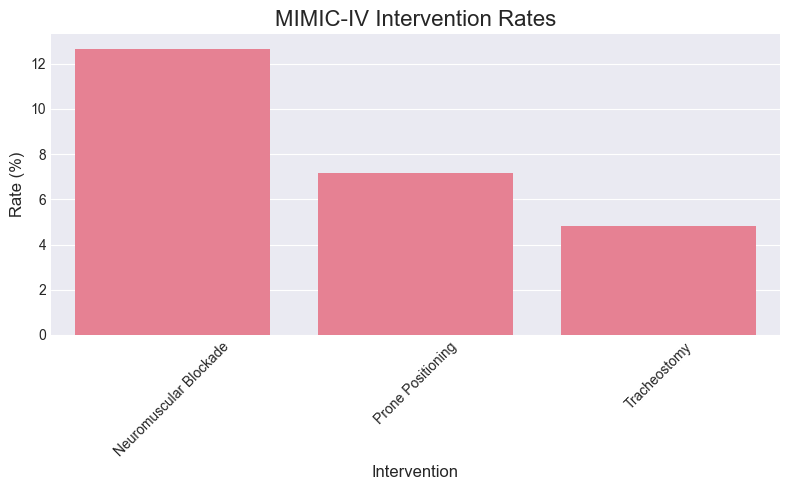


MIMIC-IV Intervention Rates:
             Intervention  Rate
0  Neuromuscular Blockade  12.7
1       Prone Positioning   7.2
2            Tracheostomy   4.8


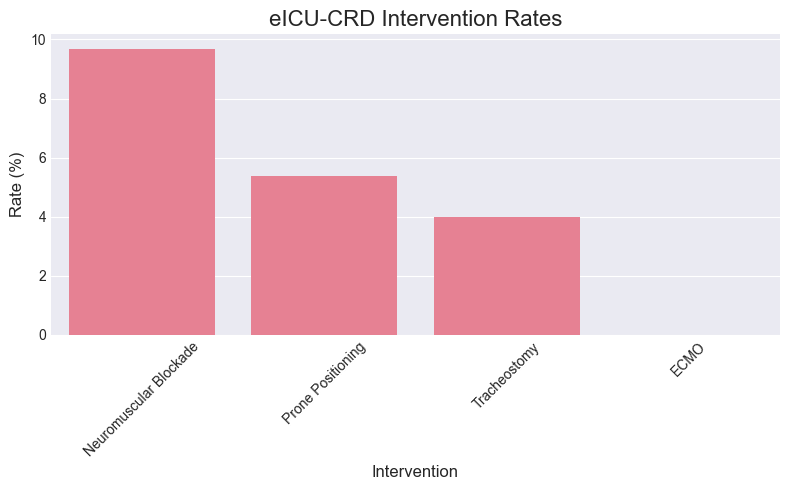


eICU-CRD Intervention Rates:
             Intervention  Rate
0  Neuromuscular Blockade   9.7
1       Prone Positioning   5.4
2            Tracheostomy   4.0
3                    ECMO   0.0


In [26]:
# Calculate intervention rates
interventions = ['nmb_used', 'prone_flag', 'new_tracheostomy']
intervention_labels = {
    'nmb_used': 'Neuromuscular Blockade',
    'prone_flag': 'Prone Positioning', 
    'new_tracheostomy': 'Tracheostomy',
    'ecmo_flag': 'ECMO'
}

# MIMIC-IV Analysis
if mimic_table1 is not None and len(mimic_table1) > 0:
    if 'ecmo_flag' in mimic_table1.columns:
        interventions.append('ecmo_flag')
        
    mimic_rates = []
    for intervention in interventions:
        if intervention in mimic_table1.columns:
            rate = mimic_table1[intervention].mean() * 100
            mimic_rates.append({
                'Intervention': intervention_labels.get(intervention, intervention),
                'Rate': rate
            })
    
    mimic_df = pd.DataFrame(mimic_rates)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=mimic_df, x='Intervention', y='Rate')
    plt.title('MIMIC-IV Intervention Rates', fontsize=16)
    plt.ylabel('Rate (%)', fontsize=12)
    plt.xlabel('Intervention', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('figures/mimic_intervention_rates.png', dpi=300)
    plt.show()
    
    print("\nMIMIC-IV Intervention Rates:")
    print(mimic_df.round(1))

# eICU Analysis
if eicu_table1 is not None and len(eicu_table1) > 0:
    if 'ecmo_flag' in eicu_table1.columns:
        interventions.append('ecmo_flag')
        
    eicu_rates = []
    for intervention in interventions:
        if intervention in eicu_table1.columns:
            rate = eicu_table1[intervention].mean() * 100
            eicu_rates.append({
                'Intervention': intervention_labels.get(intervention, intervention),
                'Rate': rate
            })
    
    eicu_df = pd.DataFrame(eicu_rates)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=eicu_df, x='Intervention', y='Rate')
    plt.title('eICU-CRD Intervention Rates', fontsize=16)
    plt.ylabel('Rate (%)', fontsize=12)
    plt.xlabel('Intervention', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('figures/eicu_intervention_rates.png', dpi=300)
    plt.show()
    
    print("\neICU-CRD Intervention Rates:")
    print(eicu_df.round(1))

### 6.2 Intervention Rates by ARDS Severity

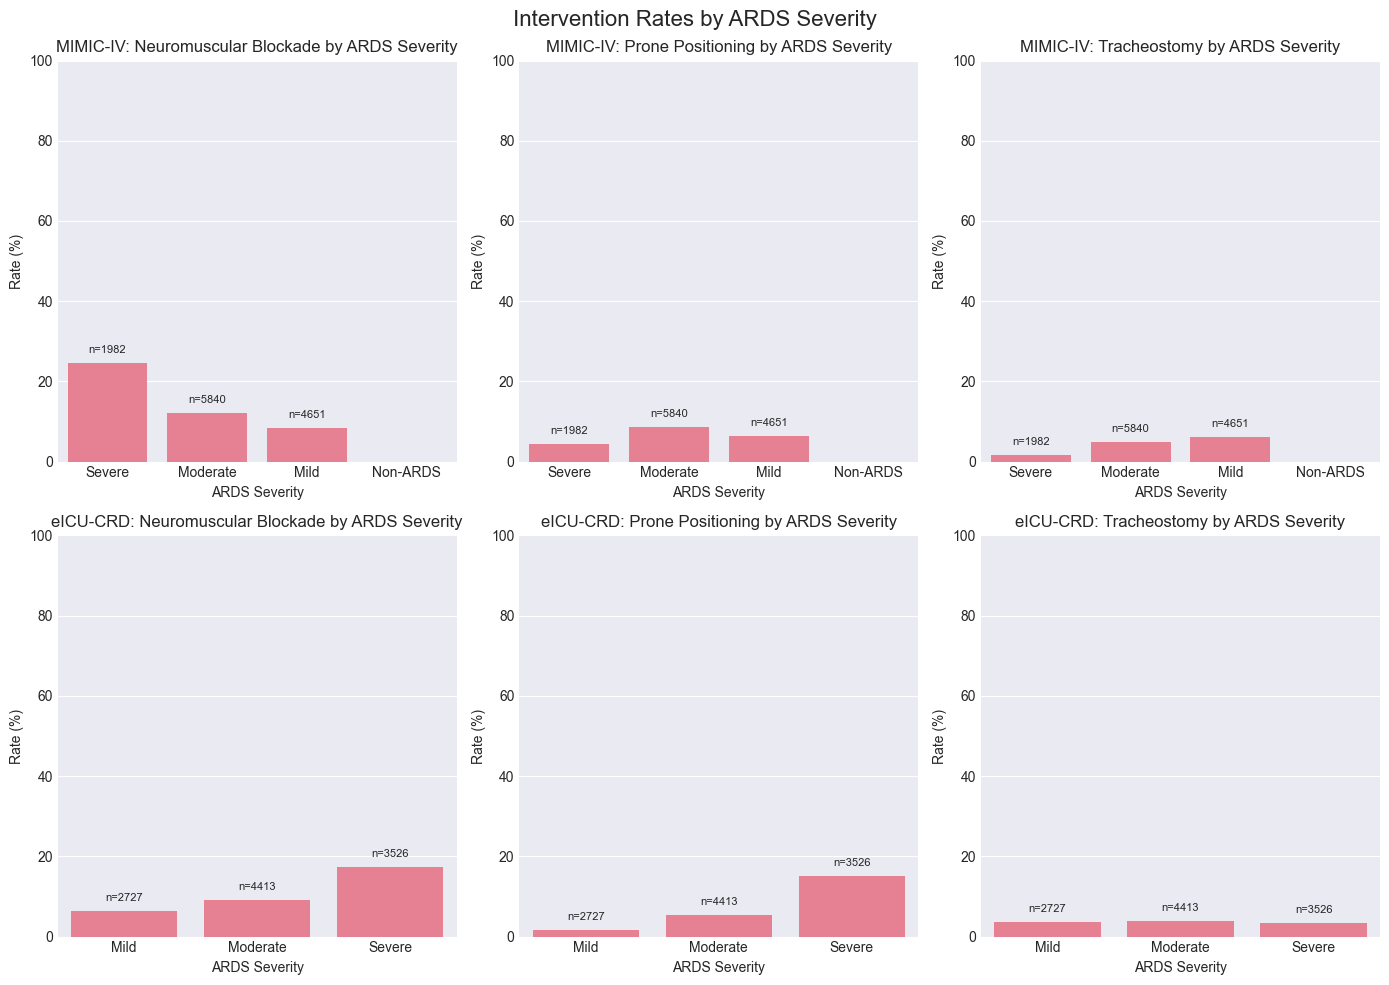

In [ ]:
# Analyze MIMIC data
if mimic_table1 is not None and 'ards_severity' in mimic_table1.columns:
    # Filter to only ARDS patients - use .isin() instead
    mimic_ards = mimic_table1[mimic_table1['ards_severity'].isin(['Mild', 'Moderate', 'Severe'])]

    if len(mimic_ards) > 0:
        # Calculate rates by severity
        fig, axes = plt.subplots(2, 3, figsize=(14, 10))

        # Filter out ECMO from interventions
        filtered_interventions = [i for i in interventions[:4] if i != 'ecmo_flag']

        for idx, intervention in enumerate(filtered_interventions):
            if intervention in mimic_ards.columns:
                # Calculate rates
                severity_rates = mimic_ards.groupby('ards_severity')[intervention].agg(['mean', 'count'])
                severity_rates['mean'] *= 100  # Convert to percentage
                severity_rates = severity_rates.reset_index()

                # Plot
                ax = axes[0, idx]
                sns.barplot(data=severity_rates, x='ards_severity', y='mean', ax=ax)
                ax.set_title(f'MIMIC-IV: {intervention_labels.get(intervention, intervention)} by ARDS Severity')
                ax.set_xlabel('ARDS Severity')
                ax.set_ylabel('Rate (%)')
                ax.set_ylim(0, 100)

                # Add sample sizes
                for i, row in severity_rates.iterrows():
                    ax.text(i, row['mean'] + 2,
                           f"n={row['count']}",
                           ha='center', va='bottom', fontsize=8)

        # Hide empty subplot if less than 3 interventions
        if len(filtered_interventions) < 3:
            axes[0, 2].set_visible(False)

# Analyze eICU data        
if eicu_table1 is not None and 'ards_severity' in eicu_table1.columns:
    # Filter to only ARDS patients - already correct
    eicu_ards = eicu_table1[eicu_table1['ards_severity'].isin(['Mild', 'Moderate', 'Severe'])]

    if len(eicu_ards) > 0:
        if not 'fig' in locals():
            fig, axes = plt.subplots(2, 3, figsize=(14, 10))

        # Filter out ECMO from interventions
        filtered_interventions = [i for i in interventions[:4] if i != 'ecmo_flag']

        for idx, intervention in enumerate(filtered_interventions):
            if intervention in eicu_ards.columns:
                # Calculate rates
                severity_rates = eicu_ards.groupby('ards_severity')[intervention].agg(['mean', 'count'])
                severity_rates['mean'] *= 100  # Convert to percentage
                severity_rates = severity_rates.reset_index()

                # Plot
                ax = axes[1, idx]
                sns.barplot(data=severity_rates, x='ards_severity', y='mean', ax=ax)
                ax.set_title(f'eICU-CRD: {intervention_labels.get(intervention, intervention)} by ARDS Severity')
                ax.set_xlabel('ARDS Severity')
                ax.set_ylabel('Rate (%)')
                ax.set_ylim(0, 100)

                # Add sample sizes
                for i, row in severity_rates.iterrows():
                    ax.text(i, row['mean'] + 2,
                           f"n={row['count']}",
                           ha='center', va='bottom', fontsize=8)

        # Hide empty subplot if less than 3 interventions
        if len(filtered_interventions) < 3:
            axes[1, 2].set_visible(False)

        plt.suptitle('Intervention Rates by ARDS Severity', fontsize=16)
        plt.tight_layout()
        plt.savefig('figures/interventions_by_severity.png', dpi=300)
        plt.show()

In [44]:
# Analyze MIMIC data
mimic_summary = pd.DataFrame()
if mimic_table1 is not None and 'ards_severity' in mimic_table1.columns:
    # Filter to only ARDS patients
    mimic_ards = mimic_table1[mimic_table1['ards_severity'].isin(['Mild', 'Moderate', 'Severe'])]

    if len(mimic_ards) > 0:
        # Filter out ECMO from interventions
        filtered_interventions = [i for i in interventions[:4] if i != 'ecmo_flag']
        
        # Create summary dataframe for MIMIC
        for intervention in filtered_interventions:
            if intervention in mimic_ards.columns:
                # Calculate rates
                severity_rates = mimic_ards.groupby('ards_severity')[intervention].agg(['mean', 'count'])
                severity_rates['mean'] *= 100  # Convert to percentage
                severity_rates = severity_rates.reset_index()
                severity_rates['intervention'] = intervention_labels.get(intervention, intervention)
                severity_rates['dataset'] = 'MIMIC-IV'
                mimic_summary = pd.concat([mimic_summary, severity_rates])

# Analyze eICU data
eicu_summary = pd.DataFrame()        
if eicu_table1 is not None and 'ards_severity' in eicu_table1.columns:
    # Filter to only ARDS patients
    eicu_ards = eicu_table1[eicu_table1['ards_severity'].isin(['Mild', 'Moderate', 'Severe'])]

    if len(eicu_ards) > 0:
        # Filter out ECMO from interventions
        filtered_interventions = [i for i in interventions[:4] if i != 'ecmo_flag']
        
        # Create summary dataframe for eICU
        for intervention in filtered_interventions:
            if intervention in eicu_ards.columns:
                # Calculate rates
                severity_rates = eicu_ards.groupby('ards_severity')[intervention].agg(['mean', 'count'])
                severity_rates['mean'] *= 100  # Convert to percentage
                severity_rates = severity_rates.reset_index()
                severity_rates['intervention'] = intervention_labels.get(intervention, intervention)
                severity_rates['dataset'] = 'eICU-CRD'
                eicu_summary = pd.concat([eicu_summary, severity_rates])

# Combine and display summaries
combined_summary = pd.concat([mimic_summary, eicu_summary])
combined_summary = combined_summary.round(2)  # Round percentages to 2 decimal places
display(combined_summary)

,ards_severity,mean,count,intervention,dataset
0,Severe,24.62,1982,Neuromuscular Blockade,MIMIC-IV
1,Moderate,12.02,5840,Neuromuscular Blockade,MIMIC-IV
2,Mild,8.39,4651,Neuromuscular Blockade,MIMIC-IV
3,Non-ARDS,NaN,0,Neuromuscular Blockade,MIMIC-IV
0,Severe,4.29,1982,Prone Positioning,MIMIC-IV
1,Moderate,8.72,5840,Prone Positioning,MIMIC-IV
2,Mild,6.49,4651,Prone Positioning,MIMIC-IV
3,Non-ARDS,NaN,0,Prone Positioning,MIMIC-IV
0,Severe,1.56,1982,Tracheostomy,MIMIC-IV
1,Moderate,4.88,5840,Tracheostomy,MIMIC-IV


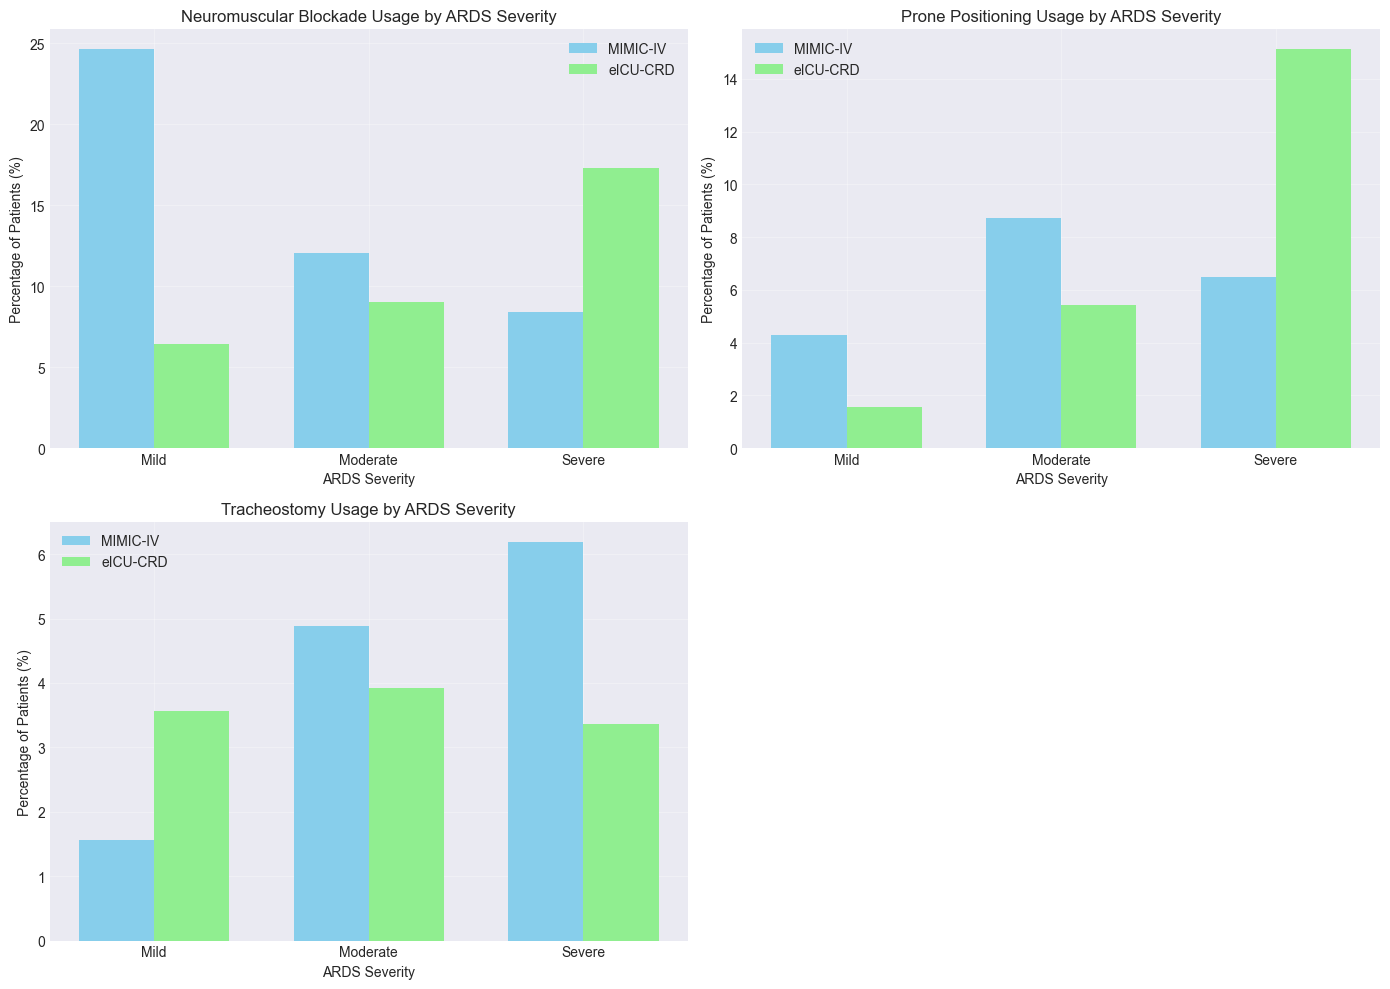

In [45]:
# Drop Non-ARDS rows from the combined summary
combined_summary = combined_summary[combined_summary['ards_severity'] != 'Non-ARDS']

# Create figure with larger size for better readability
plt.figure(figsize=(14, 10))

# Create subplots for each intervention
interventions = combined_summary['intervention'].unique()
n_interventions = len(interventions)
n_cols = 2
n_rows = (n_interventions + 1) // 2

for idx, intervention in enumerate(interventions, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    # Filter data for this intervention
    intervention_data = combined_summary[combined_summary['intervention'] == intervention]
    
    # Create grouped bar plot
    bar_width = 0.35
    x = np.arange(len(intervention_data['ards_severity'].unique()))
    
    # Plot bars for each dataset
    mimic_data = intervention_data[intervention_data['dataset'] == 'MIMIC-IV']
    eicu_data = intervention_data[intervention_data['dataset'] == 'eICU-CRD']
    
    plt.bar(x - bar_width/2, mimic_data['mean'], bar_width, label='MIMIC-IV', color='skyblue')
    plt.bar(x + bar_width/2, eicu_data['mean'], bar_width, label='eICU-CRD', color='lightgreen')
    
    plt.title(f'{intervention} Usage by ARDS Severity')
    plt.xlabel('ARDS Severity')
    plt.ylabel('Percentage of Patients (%)')
    plt.xticks(x, ['Mild', 'Moderate', 'Severe'])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 6.3 Time to Proning Analysis

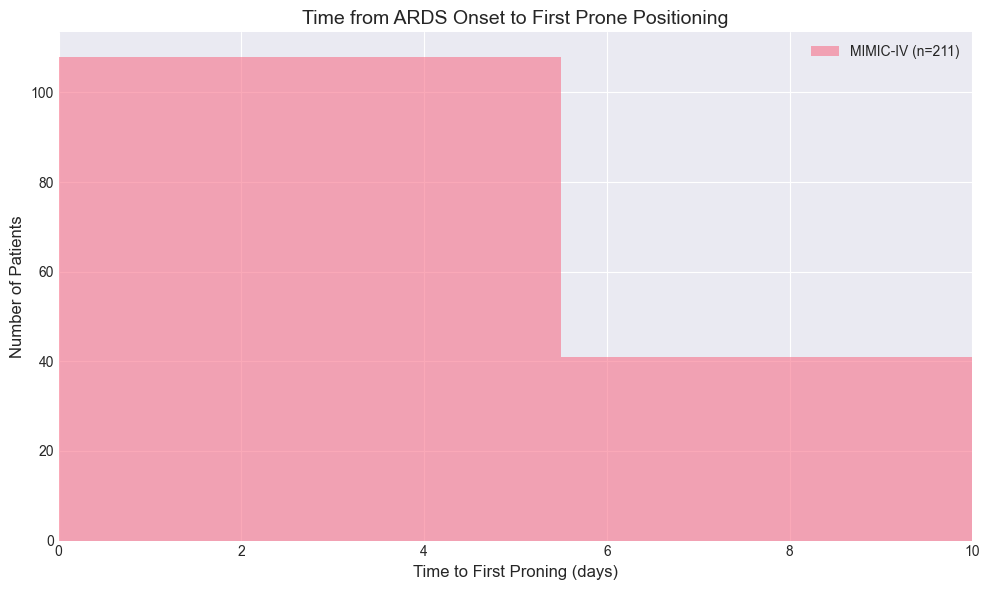


Time to Proning Summary (days):
            N  Mean  Median     SD    Q1     Q3
dataset                                        
MIMIC-IV  211  7.09    3.68  12.53  1.07  10.27


In [47]:
# For time to proning, we need the full time series data
def analyze_time_to_proning(ts_data, dataset_name):
    """
    Analyze time from ARDS onset to first proning
    """
    if ts_data is None or 'prone_flag' not in ts_data.columns:
        return None
        
    # Get patients who were proned
    proned_patients = ts_data[ts_data['prone_flag'] == 1]['patient_id'].unique()
    
    if len(proned_patients) == 0:
        return None
        
    time_to_prone = []
    
    for patient_id in proned_patients:
        patient_data = ts_data[ts_data['patient_id'] == patient_id]
        
        # Find first prone event
        prone_events = patient_data[patient_data['prone_flag'] == 1]
        if len(prone_events) > 0:
            # Get time from ARDS onset if available
            if 'time_from_ARDS_onset' in prone_events.columns:
                first_prone_time = prone_events['time_from_ARDS_onset'].min()
            elif 'hours_from_ards_onset' in prone_events.columns:
                first_prone_time = prone_events['hours_from_ards_onset'].min()
            else:
                # Use hours from ICU admission as fallback
                if 'hours_from_icu_admission' in prone_events.columns:
                    first_prone_time = prone_events['hours_from_icu_admission'].min()
                else:
                    continue
                    
            time_to_prone.append({
                'patient_id': patient_id,
                'time_to_prone_hours': first_prone_time,
                'dataset': dataset_name
            })
    
    return pd.DataFrame(time_to_prone)

# Analyze time to proning for both datasets
mimic_prone_times = None
eicu_prone_times = None

if mimic_ts is not None:
    # Add patient_id column if not present
    if 'patient_id' not in mimic_ts.columns and 'hospitalization_id' in mimic_ts.columns:
        mimic_ts['patient_id'] = mimic_ts['hospitalization_id']
    mimic_prone_times = analyze_time_to_proning(mimic_ts, 'MIMIC-IV')
    
if eicu_data is not None:
    eicu_prone_times = analyze_time_to_proning(eicu_data, 'eICU-CRD')

# Combine results
all_prone_times = []
if mimic_prone_times is not None:
    all_prone_times.append(mimic_prone_times)
if eicu_prone_times is not None:
    all_prone_times.append(eicu_prone_times)
    
if all_prone_times:
    prone_times_df = pd.concat(all_prone_times, ignore_index=True)
    
    # Convert to days
    prone_times_df['time_to_prone_days'] = prone_times_df['time_to_prone_hours'] / 24
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    
    for dataset in prone_times_df['dataset'].unique():
        dataset_times = prone_times_df[prone_times_df['dataset'] == dataset]['time_to_prone_days']
        plt.hist(dataset_times, bins=20, alpha=0.6, label=f"{dataset} (n={len(dataset_times)})")
    
    plt.xlabel('Time to First Proning (days)', fontsize=12)
    plt.ylabel('Number of Patients', fontsize=12)
    plt.title('Time from ARDS Onset to First Prone Positioning', fontsize=14)
    plt.legend()
    plt.xlim(0, 10)  # Focus on first 10 days
    plt.tight_layout()
    plt.savefig('figures/time_to_proning_distribution.png', dpi=300)
    plt.show()
    
    # Summary statistics
    print("\nTime to Proning Summary (days):")
    summary = prone_times_df.groupby('dataset')['time_to_prone_days'].agg([
        'count', 'mean', 'median', 'std',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75)
    ])
    summary.columns = ['N', 'Mean', 'Median', 'SD', 'Q1', 'Q3']
    print(summary.round(2))
else:
    print("No time to proning data available")

### 6.4 Respiratory Parameters by Dataset

In [ ]:
if combined_data is not None:
    # Respiratory parameters to compare
    resp_params = ['peep', 'fio2', 'pf_ratio', 'sf_ratio']
    resp_labels = {
        'peep': 'PEEP (cmH2O)',
        'fio2': 'FiO2 (%)',
        'pf_ratio': 'P/F Ratio',
        'sf_ratio': 'S/F Ratio'
    }
    
    # Create violin plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, param in enumerate(resp_params):
        if param in combined_data.columns:
            ax = axes[idx]
            
            # Filter out extreme/invalid values
            param_data = combined_data[combined_data[param].notna()].copy()
            
            if param == 'peep':
                param_data = param_data[param_data[param] <= 30]
            elif param == 'fio2':
                param_data = param_data[(param_data[param] >= 21) & (param_data[param] <= 100)]
            elif param in ['pf_ratio', 'sf_ratio']:
                param_data = param_data[param_data[param] <= 500]
                
            if len(param_data) > 0:
                sns.violinplot(data=param_data, x='dataset', y=param, ax=ax)
                ax.set_title(resp_labels.get(param, param))
                ax.set_xlabel('Dataset')
                ax.set_ylabel(resp_labels.get(param, param))
                
                # Add median lines
                medians = param_data.groupby('dataset')[param].median()
                for i, dataset in enumerate(param_data['dataset'].unique()):
                    ax.text(i, medians[dataset], f"{medians[dataset]:.1f}", 
                           ha='center', va='bottom', fontweight='bold')
        else:
            axes[idx].set_visible(False)
    
    plt.suptitle('Respiratory Parameters: MIMIC-IV vs eICU-CRD', fontsize=16)
    plt.tight_layout()
    plt.savefig('../results/figures/respiratory_parameters_comparison.png', dpi=300)
    plt.show()

### 6.5 Outcomes by Intervention

In [ ]:
if combined_data is not None and 'mortality' in combined_data.columns:
    # Analyze mortality by intervention use
    interventions_to_analyze = ['nmb_used', 'prone_flag']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for idx, intervention in enumerate(interventions_to_analyze):
        if intervention in combined_data.columns:
            ax = axes[idx]
            
            # Calculate mortality rates
            mortality_by_intervention = combined_data.groupby(['dataset', intervention])['mortality'].agg(['mean', 'count'])
            mortality_by_intervention['mean'] *= 100  # Convert to percentage
            mortality_by_intervention = mortality_by_intervention.reset_index()
            
            # Create labels
            mortality_by_intervention['Intervention'] = mortality_by_intervention[intervention].map({
                0: f'No {intervention_labels.get(intervention, intervention)}',
                1: f'{intervention_labels.get(intervention, intervention)}'
            })
            
            # Plot
            sns.barplot(data=mortality_by_intervention, x='Intervention', y='mean', hue='dataset', ax=ax)
            ax.set_ylabel('Mortality Rate (%)')
            ax.set_xlabel('')
            ax.set_title(f'Mortality by {intervention_labels.get(intervention, intervention)} Use')
            ax.set_ylim(0, 60)
            
            # Add sample sizes
            for i, (_, row) in enumerate(mortality_by_intervention.iterrows()):
                x_pos = i % 2 - 0.2 + (0.4 if row['dataset'] == 'eICU-CRD' else 0)
                ax.text(x_pos, row['mean'] + 1, f"n={row['count']}", 
                       ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Mortality Rates by Intervention Use', fontsize=14)
    plt.tight_layout()
    plt.savefig('../results/figures/mortality_by_intervention.png', dpi=300)
    plt.show()
    
    # Statistical comparison
    print("\nMortality Analysis by Intervention:")
    for intervention in interventions_to_analyze:
        if intervention in combined_data.columns:
            print(f"\n{intervention_labels.get(intervention, intervention)}:")
            for dataset in combined_data['dataset'].unique():
                dataset_data = combined_data[combined_data['dataset'] == dataset]
                with_intervention = dataset_data[dataset_data[intervention] == 1]['mortality'].mean() * 100
                without_intervention = dataset_data[dataset_data[intervention] == 0]['mortality'].mean() * 100
                print(f"  {dataset}: With={with_intervention:.1f}%, Without={without_intervention:.1f}%")

## 7. Summary Statistics

In [ ]:
# Create summary report
if combined_data is not None:
    print("\n" + "="*80)
    print("SUMMARY REPORT: MIMIC-IV vs eICU-CRD ARDS Cohorts")
    print("="*80)
    
    for dataset in ['MIMIC-IV', 'eICU-CRD']:
        dataset_data = combined_data[combined_data['dataset'] == dataset]
        
        if len(dataset_data) > 0:
            print(f"\n{dataset} Summary:")
            print(f"  Total patients: {len(dataset_data)}")
            print(f"  Age: {dataset_data['age'].mean():.1f} ± {dataset_data['age'].std():.1f} years")
            print(f"  Male: {(dataset_data['gender'].str.upper() == 'M').mean() * 100:.1f}%")
            print(f"  Mortality: {dataset_data['mortality'].mean() * 100:.1f}%")
            
            if 'ards_severity' in dataset_data.columns:
                severity_dist = dataset_data['ards_severity'].value_counts(normalize=True) * 100
                print("  ARDS Severity:")
                for severity in ['Mild', 'Moderate', 'Severe']:
                    if severity in severity_dist:
                        print(f"    {severity}: {severity_dist[severity]:.1f}%")
            
            print("  Interventions:")
            if 'nmb_used' in dataset_data.columns:
                print(f"    NMB: {dataset_data['nmb_used'].mean() * 100:.1f}%")
            if 'prone_flag' in dataset_data.columns:
                print(f"    Proning: {dataset_data['prone_flag'].mean() * 100:.1f}%")
            if 'new_tracheostomy' in dataset_data.columns:
                print(f"    Tracheostomy: {dataset_data['new_tracheostomy'].mean() * 100:.1f}%")
            if 'ecmo_flag' in dataset_data.columns:
                print(f"    ECMO: {dataset_data['ecmo_flag'].mean() * 100:.1f}%")
    
    print("\n" + "="*80)
    print("Analysis complete. Results saved to ../results/")
    print("="*80)